Creator: Ryan Corbyn
Date created: 16/10/2020

Edited:     Name         Date

This is a program that is designed to load in data from a full CW ODMR measurement. 

From here, the line scans are averaged to give the mean ODMR spectra, this is then plotted as a scatter graph and a double lorentzian line shape is fitted to the data. 

The fitting parameters are saved to a data file, along with the plot. 

In [1]:
import scipy.optimize as opt 
import numpy as np 
import matplotlib.pyplot as plot 
import os 
import pandas as pd

In [2]:
def load_data(file_path): 
    # load the ODMR data file in to an np array 
    data_array = np.loadtxt(file_path)
    return(data_array)

In [3]:
def load_params(file_path):
    # load in the params data. 
    params_data = pd.read_table(file_path, names = ['Parameter name', 'Parameter value']) 
    return(params_data)

In [4]:
def create_freq_scan(start, stop, step_size):
    # takes the scan parameters from the params data file. 
    step_size_GHz = step_size/1000
    number_of_steps = int((stop-start)/step_size_GHz)+1
    freq = np.linspace(start, stop, number_of_steps)
    
    return(freq)

In [5]:
def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 20})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

In [6]:
def plot_heat_map(freq, odmr_data, dwell_time):
    # plot the full ODMR data as a heatmap. 
    number_of_scans = len(odmr_data)
    Y = np.linspace(1, number_of_scans, number_of_scans) 
    
    fig1, ax1 = plot.subplots()
    
    hm = ax1.pcolormesh(freq, Y, odmr_data, cmap = 'viridis')
    fig1.colorbar(hm, label = '\ncounts per ' + str(dwell_time) + r' $\mu$s')
    ax1.set_xlim(np.min(freq),np.max(freq))
    ax1.set_xticks(np.arange(np.min(freq), np.max(freq), 0.05))
    ax1.set_xlabel('Microwave Frequency (GHz)')
    ax1.set_ylabel('Number of scans')
    
    return(fig1, ax1)

In [7]:
def mean_data(odmr_data):
    # find the mean data 
    mean_odmr_data =  np.mean(odmr_data, axis=0)
    return(mean_odmr_data)

In [8]:
def normalise_data(mean_odmr_data):
    # normalise the data to the maximum value of the mean dataset. 
    norm_odmr_data = mean_odmr_data/(np.max(mean_odmr_data))
    return(norm_odmr_data)

In [9]:
def scatter_plot(freq,mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    ax2.set_xlim(np.min(freq),np.max(freq))
    return(fig2, ax2)

In [10]:
def get_init_params(odmr_data, freq):
    # find the minima of the ODMR spectra and ODMR dip contrast and 
    # flourenscent baseline.
    half_data_length = int((len(freq)-1)/2)
    
    #find the indices for the lowest frequency value
    low_freq_min_index = np.where(odmr_data[0:half_data_length] == np.min(odmr_data[0:half_data_length]))
    high_freq_min_index = np.where(odmr_data[half_data_length:len(odmr_data)-1] == 
                                   np.min(odmr_data[half_data_length:len(odmr_data)-1]))
   
    # frequencies corresponding to ODMR minima
    freq_mins = [np.float(freq[low_freq_min_index[0]]),
                 np.float(freq[high_freq_min_index[0]+half_data_length])]
    
    # manually set frequencies. 
    
    #freq_mins = [2.78, 2.96]
    
    flourescent_baseline = np.mean(odmr_data)
    
    # approximate contrast for ODMR peaks
    contrast = [np.float((1-odmr_data[low_freq_min_index[0]]/flourescent_baseline)), 
                np.float((1-odmr_data[high_freq_min_index[0]+half_data_length]/flourescent_baseline))]

    return(freq_mins, contrast, flourescent_baseline)

In [11]:
def optimised_lorentz_fit(freq, mean_data, init_params):
    # A method to find the fitting prameters for the ODMR dataset. 
    y_error = np.sqrt(mean_data) # poissonian noise
    coeffs, confidence = opt.curve_fit(double_lorentz, freq, mean_data, init_params, sigma = y_error)
    opt_error = np.sqrt(np.diag(confidence))
    
    return(coeffs, opt_error)

In [12]:
def double_lorentz(x, A1, X01, sig1, A2, X02, sig2, offset): #P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # A1 = Amplitude 1, X01 = Resonance 1, sig1 = FWHM 1
    # A2 = Amplitude 2, X02 = Resonance 2, sig2 = FWHM 2, offset = offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return (first_peak + second_peak + offset)

In [13]:
def plot_fitting(ax2, freq, y_fit):
    # plot the y fit. 
    
    ax2.plot(freq, y_fit, color='k', label='Double Lorentz \nfitting')
    ax2.legend()
    ax2.set_xlabel('Microwave Frequency (GHz)', fontsize = 18)
    ax2.set_ylabel('Normalised Counts', fontsize = 18)
    
    return(ax2)
 

In [14]:
def get_r_squared(x, y_data, y_fitting):
    # This is a function used to generate the goodness of fit metric r^2.
    # This value will be used to judge the effectiveness of the curve fitting 
    # used to find the resonant frequencies of the NV centre.
    
    y_data_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_data_mean)**2) # Find the variation in experimental y values.
    SSres = np.sum((y_data - y_fitting)**2) # Find the variation betweem the experimental and fitted y values. 
    
    r_squared = 1 - (SSres/SStot) # Calculate R^2
    
    return(r_squared)

In [15]:
def save_data(date, file_ID, contrast, coeffs, opt_error, r_squared, nd_number, temp, fig1, fig2):
    
    destination_folder = 'H:\\My Documents\\Strathclyde_Back_up\\Graphs_and_analysis\\Thermometry\\' + date + '\\'
    output_data_file = destination_folder + date + '_NVScan_analysis.dat'
    
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('File name' +  ', \t' + 'ND' + '\t' + 'Temperature (oC)' + '\t' +
                     'Resonant frequency 1 (GHz)' + '\t' + 'Error Resonant frequency 1 (GHz)' + '\t' + 
                     'Resonant frequency 1 contrast (%)' + '\t' + 
                     'FWHM 1 (MHz)' + '\t' + 'FWHM 1 error (MHz)' + '\t' + 
                     'Resonant frequency 2 (GHz)' + '\t' + 'Error Resonant frequency 2 (GHz)' + '\t' + 
                     'Resonant frequency2 contrast (%)' + '\t' + 
                     'FWHM 2 (MHz)' + '\t' + 'FWHM 2 error (MHz)' + '\t' + 
                     'Off Res Fluorescence intensity (per dwell time)' + '\t' +'R^2 for fitting' +'\n')
    # Writing contrast dip description to the .dat file
    
    with open(output_data_file, "a") as wf:
        wf.write(file_ID + ' \t' +  str(nd_number) + '\t' + str(temp) + '\t' +
                 str(coeffs[1]) + " \t"  + str(opt_error[1]) + " \t" + 
                 str(contrast[0]*100) + " \t"  +  
                 str(abs(coeffs[2])*1000) + " \t" + str(opt_error[2]*1000) + " \t" + 
                 str(coeffs[4]) + " \t"  + str(opt_error[4]) + " \t" + 
                 str(contrast[1]*100) + " \t" +
                 str(abs(coeffs[5])*1000) + " \t" + str(opt_error[5]*1000) + " \t" + 
                 str(coeffs[6]) + " \t" +str(r_squared) + '\n')
        
    # Saving a plot of the raw data to a folder. 
    fig1.savefig(destination_folder + file_ID + '_heatmap.pdf', transparent = True)    
    fig1.savefig(destination_folder + file_ID + '_heatmap.png', transparent = True) 
    
    fig2.savefig(destination_folder + file_ID + '.pdf', transparent = True)    
    fig2.savefig(destination_folder + file_ID + '.png', transparent = True) 
    

0.8662209610099546


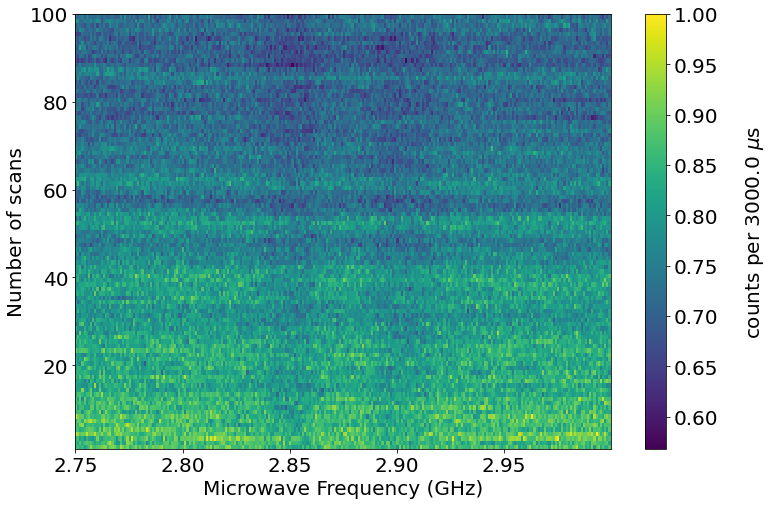

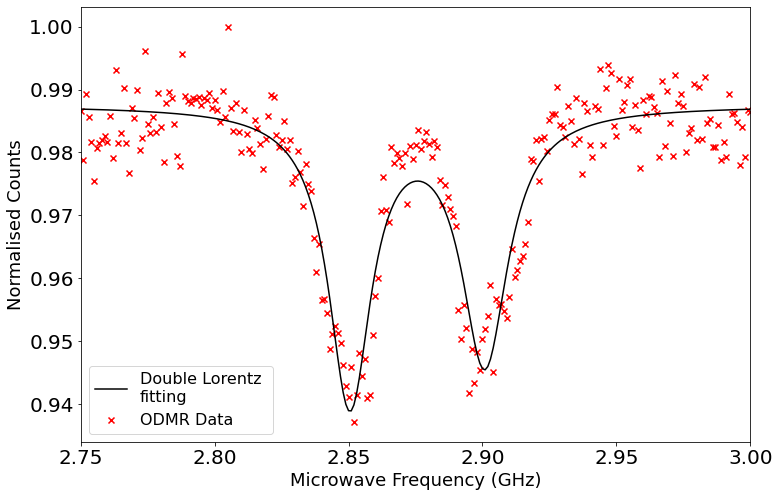

In [17]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
 # Saves this data into a text file and the 2 plots generated. 
#######

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\'
date = '20201022'
file_name = date + '_NVScan_01'

odmr_data = load_data(folder_path + date + '\\' + file_name + '.dat')
params_file = load_params(folder_path + date + '\\' + file_name + 'Params.dat')
params_values = params_file['Parameter value']

# Create the freqeuncy scan array. 
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])

# plot a colour map of the ODMR data and set plot format for the program. 
set_plot_params()

odmr_data = normalise_data(odmr_data)

fig1, ax1 = plot_heat_map(freq, odmr_data, params_values[3])

# find the mean of the ODMR data
mean_odmr_data = mean_data(odmr_data)
# Normalise the dataset
norm_mean_odmr = normalise_data(mean_odmr_data)

# scatter plot of data
fig2, ax2 = scatter_plot(freq, norm_mean_odmr)

# find the freqeuncy points with the highest ODMR contrast
freq_mins, contrast, flourescent_baseline = get_init_params(norm_mean_odmr, freq)

# create the initial parameters for ODMR double lorentzian 
# line fitting
init_params = [contrast[0], freq_mins[0], 0.001, contrast[1], freq_mins[1], 0.001, flourescent_baseline]

# generate the optimised curve fit parameters. 
fitting_params, error_in_fit = optimised_lorentz_fit(freq, norm_mean_odmr, init_params)

# create the double lorentz fit array
y_fit = double_lorentz(freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])

# plot the fitting to ax2
ax2 = plot_fitting(ax2, freq, y_fit)
    
# get the r^2 value for the fitting 
r_squared = get_r_squared(freq, norm_mean_odmr, y_fit)
print(r_squared)

#save_data(date, file_name, contrast, fitting_params, error_in_fit, r_squared, nd_number, temp, fig1, fig2)

0.06710497618875344
